In [5]:
import numpy as np
import pandas as pd

%matplotlib notebook
import matplotlib.pyplot as plt

In [3]:
data = pd.read_csv("Prieto06.tab5")

In [23]:
normal = np.where((data['dm15'] > 0.8) & (data['dm15'] < 1.7))
print(np.mean(data['dm15'].iloc[normal]), np.std(data['dm15'].iloc[normal], ddof=1))

1.1308953488372093 0.25976627635444394


From [Yasuda & Fukugita (2010)](http://adsabs.harvard.edu/abs/2010AJ....139...39Y), it is found that $M_B \sim \mathcal{N}(-19.3, 0.2)$. From [Prieto et al. (2006)](http://adsabs.harvard.edu/abs/2006ApJ...647..501P) a fit is performed to $M_B$ vs $\delta{m}_{15}$, which results in a slope of $b = 0.63$. For the Prieto sample we further find a sample mean and standard deviation of ~1.1 and 0.3, respectively (note this distribution isn't strictly Gaussian). Thus, the covariance between $M_B$ and $\delta{m}_{15}$ is $\approx 0.042$. 

From all this we can describe a SN Ia as coming from a multivariate normal distribution:

$$X \sim \mathcal{N}\left(\begin{bmatrix} -19.3 \\ 1.1 \end{bmatrix}, \begin{bmatrix} 0.04 & 0.042 \\ 0.042 & 0.09\end{bmatrix} \right)$$

We can now draw random samples from this multivariate normal in order to select the peak brightness and decline rate of the SN. 

In [14]:
sne = np.random.multivariate_normal([-19.3,1.1],[[0.04,0.042],[0.042,0.09]], 100)

<IPython.core.display.Javascript object>


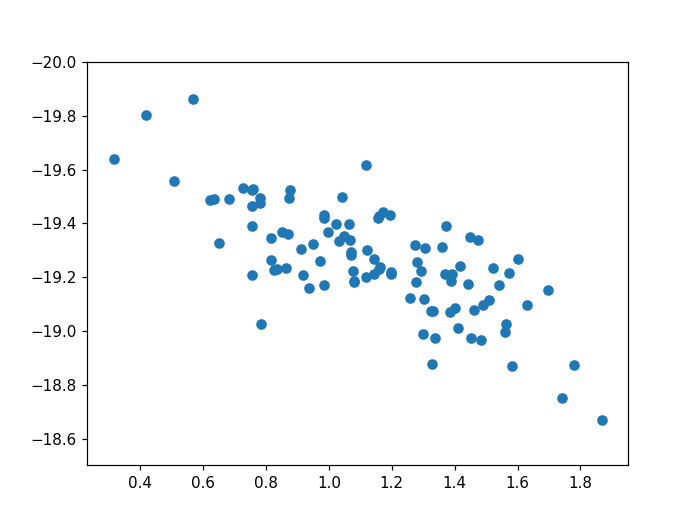

(-18.5, -20)

In [22]:
plt.scatter(sne[:,1], sne[:,0])
plt.ylim(-18.5,-20)

## Sample from Burns 18 sample

In [Burns et al. 2018](https://iopscience.iop.org/article/10.3847/1538-4357/aae51c/meta) data is provided for $M_B$ and $\Delta m_{15}(B)$ for ~140 SNe. From this uniform sample it is possible to build a 2D PDF using a Gaussian KDE, and from there the peak and decline rate of SNe Ia can be drawn. This represents an improvement over the ad hoc method using data from Prieto et al. below.

In [42]:
dm15_df = pd.read_csv("/Users/adamamiller/astronomy/SN_Ia_models/ObsData/Burns18/Burns18.tab2_pd", 
                       delimiter=' ')
mmax_df = pd.read_csv("/Users/adamamiller/astronomy/SN_Ia_models/ObsData/Burns18/st_template_fits_DR3.dat")
mass_df = pd.read_csv("/Users/adamamiller/astronomy/SN_Ia_models/ObsData/Burns18/CSPI_masses.dat")

In Burns et al. 2018, there is a host-mass term to correct the observed absolute magnitude of SNe Ia. The host mass can be calculated as:

$$ \log(M_\ast/M_\odot) = -0.4(m_K - \mu) + C$$

where $C = 1.04$ (note the typo in Burns et al. that says $C = -1.04$). 

In [124]:
b_band = np.where(mmax_df['f'] == 'B')

In [43]:
tmp_df = pd.merge(dm15_df, mmax_df.iloc[b_band], left_on='SN', right_on='name', how='inner')
dat_df = pd.merge(tmp_df, mass_df, on='name', how='inner')

In [238]:
log_host_mass = -0.4*(dat_df['K'].values - dat_df['muCV'].values) + 1.04
no_kmag = np.where(dat_df['K'] == -1.0)
log_host_mass[no_kmag] = dat_df['M2'].iloc[no_kmag]
zcmb = dat_df['zcmb_x'].values

mu = dat_df['muCV'].values
b_max = dat_df['Mmax'].values
reddening = dat_df['EBV'].values*(dat_df['Rv'].values+1)
sbv = dat_df['sBV'].values
ebv = dat_df['EBV'].values
q = dat_df['q'].values

alpha = -0.084*np.ones_like(sbv)

# alpha[np.where(sbv > 0.5)] = -0.076
# alpha[np.where(ebv < 0.5)] = -0.079
# alpha[np.where((ebv < 0.5) & (sbv > 0.5))] = -0.068

m_b = b_max - mu - reddening + alpha*(log_host_mass-11)
dm_15 = dat_df['dm15'].values

host_mass = np.where((dat_df['K'] != -1.0) | (dat_df['M2'] != -1))
host_mass_high_z = np.where(((dat_df['K'] != -1.0) | (dat_df['M2'] != -1)) & (zcmb > 0.01))
good_sn = np.where(((dat_df['K'] != -1.0) | (dat_df['M2'] != -1)) & 
                   (zcmb > 0.01) & (q >= 0.4) & (sbv > 0.5) & (dm_15 < 1.7))

<IPython.core.display.Javascript object>


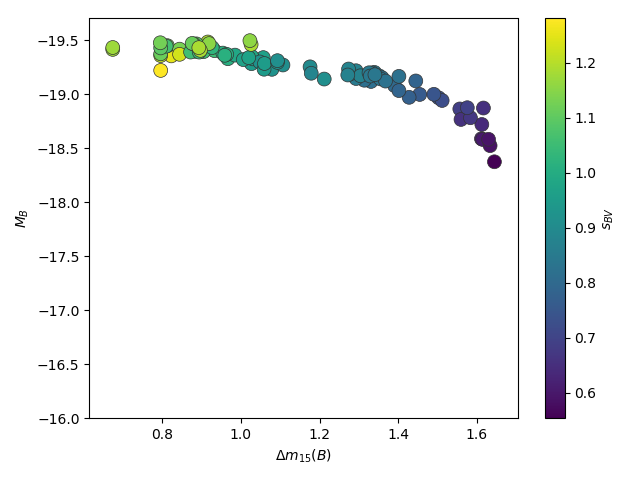

In [240]:
fig, ax = plt.subplots()
sax = ax.scatter(dm_15[good_sn], m_b[good_sn], c=sbv[good_sn],
                 edgecolor='0.2', linewidths=0.5, s=100)

ax.set_ylim(-16,-19.7)
ax.set_xlabel('$\Delta m_{15}(B)$')
ax.set_ylabel('$M_B$')

cbar = fig.colorbar(sax)
cbar.set_label('$s_{BV}$')
fig.tight_layout()

## Create KDE estimate of Phillips relation

In [241]:
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

raw_phillips = np.vstack((dm_15[good_sn], m_b[good_sn])).T
phillips_scaler = StandardScaler().fit(raw_phillips)

params = {'bandwidth': np.logspace(-2, 0, 100)}
grid = GridSearchCV(KernelDensity(), params, cv=10)
grid.fit(phillips_scaler.transform(raw_phillips))

/Users/adamamiller/miniconda3/envs/emcee3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=KernelDensity(algorithm='auto', atol=0, bandwidth=1.0, breadth_first=True,
       kernel='gaussian', leaf_size=40, metric='euclidean',
       metric_params=None, rtol=0),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'bandwidth': array([0.01   , 0.01048, ..., 0.95455, 1.     ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

<IPython.core.display.Javascript object>


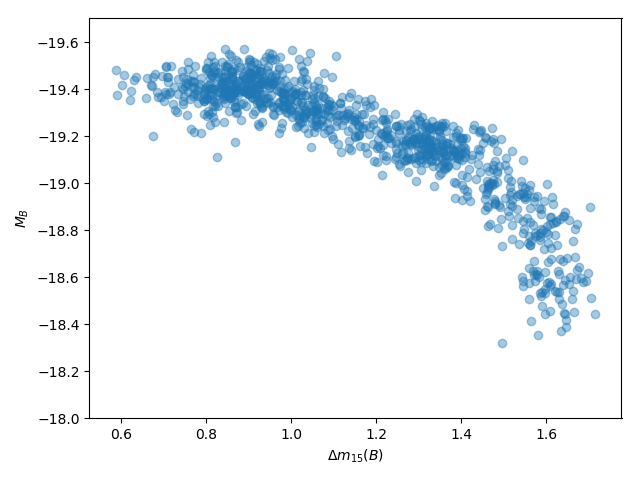

In [246]:
kde = grid.best_estimator_
new_data = kde.sample(1000, random_state=0)

fig, ax = plt.subplots()
ax.scatter(phillips_scaler.inverse_transform(new_data)[:,0], 
            phillips_scaler.inverse_transform(new_data)[:,1], 
            alpha=0.4)
ax.set_ylim(-18,-19.7)
ax.set_xlabel('$\Delta m_{15}(B)$')
ax.set_ylabel('$M_B$')
fig.tight_layout()

To draw a single random "normal" SN Ia from the distribution, you can grab and scale one point from the KDE.

In [247]:
new_data = kde.sample(1)            
phillips_scaler.inverse_transform(new_data)

array([[  1.39472059, -18.97317147]])

Finally, the model must be saved so the distribution can be drawn from randomly when simulating SNe

In [248]:
import pickle

sn_tuple = (kde, phillips_scaler)
pkl_filename = "phillips_kde.pkl"  
with open(pkl_filename, 'wb') as file:  
    pickle.dump(sn_tuple, file)